Name: Feifan Gu /
Github Username: Feifan126 /
USC ID: 8135699631

### 1. Multi-class and Multi-Label Classification Using Support Vector Machines

(a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "../data/Frogs_MFCCs.csv"
df = pd.read_csv(file_path)

# Shuffle and split 70% train, 30% test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, shuffle=True)

# Output size of splits
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

# (Optional) View first few rows
print(train_df.head())

Training set size: 5036
Test set size: 2159
      MFCCs_ 1  MFCCs_ 2  MFCCs_ 3  MFCCs_ 4  MFCCs_ 5  MFCCs_ 6  MFCCs_ 7  \
2004  1.000000  0.327476  0.282440  0.572211  0.096509 -0.036705 -0.082174   
1194  1.000000  0.232818 -0.144331 -0.078909 -0.072467  0.255380  0.450215   
5359  0.966443  0.455914  1.000000  0.541650 -0.412873  0.307099  0.235819   
1756  1.000000  0.257873  0.112807  0.527614  0.186094  0.043683 -0.163682   
497   1.000000  0.401859  0.563219  0.578304 -0.126517 -0.058725  0.431806   

      MFCCs_ 8  MFCCs_ 9  MFCCs_10  ...  MFCCs_17  MFCCs_18  MFCCs_19  \
2004  0.146604  0.297338 -0.120902  ...  0.218024 -0.042083 -0.126511   
1194  0.261033 -0.168462 -0.281445  ... -0.291979 -0.042932 -0.009021   
5359 -0.064025  0.069728 -0.052552  ... -0.049428 -0.053166 -0.026728   
1756 -0.014125  0.196527  0.018839  ...  0.226971  0.034969 -0.106029   
497   0.066801 -0.321014  0.155569  ... -0.002891  0.157072 -0.015251   

      MFCCs_20  MFCCs_21  MFCCs_22           Fam

(b) Each instance has three labels: Families, Genus, and Species.

i. Research exact match and hamming score/ loss methods for evaluating multi-
label classification and use them in evaluating the classifiers in this problem.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Extract features and target labels
feature_cols = train_df.columns[:22]  # The first 22 columns are MFCC features
label_cols = ['Family', 'Genus', 'Species']  # Multi-label targets

X_train = train_df[feature_cols]
y_train = train_df[label_cols]
X_test = test_df[feature_cols]
y_test = test_df[label_cols]

# Encode the labels to integers
label_encoders = {}
y_train_enc = pd.DataFrame()
y_test_enc = pd.DataFrame()

for col in label_cols:
    le = LabelEncoder()
    y_train_enc[col] = le.fit_transform(y_train[col])  # Fit and transform training labels
    y_test_enc[col] = le.transform(y_test[col])          # Transform test labels using the same encoder
    label_encoders[col] = le                             # Store encoder for later inverse transformation

# Build and train a multi-label model (using RandomForest as the base classifier)
base_clf = RandomForestClassifier(n_estimators=100, random_state=42)
multi_model = MultiOutputClassifier(base_clf)
multi_model.fit(X_train, y_train_enc)

# Predict on the test set
y_pred_enc = multi_model.predict(X_test)

# Convert the predictions and true labels to NumPy arrays
y_true_array = y_test_enc.values
y_pred_array = np.array(y_pred_enc)

# Evaluation Metrics (Manual Computation)
# Exact match (subset accuracy): the proportion of samples where all label predictions match the true labels exactly.
exact_match = np.mean(np.all(y_true_array == y_pred_array, axis=1))

# Hamming loss: the average fraction of misclassified labels.
hamming_loss_manual = np.mean(y_true_array != y_pred_array)

# Hamming score: defined as 1 - Hamming loss.
hamming_score_manual = 1 - hamming_loss_manual

print(f"✅ Exact Match Accuracy (Subset Accuracy): {exact_match:.4f}")
print(f"⚠️ Hamming Loss (Manual): {hamming_loss_manual:.4f}")
print(f"📈 Hamming Score (Manual): {hamming_score_manual:.4f}")

# Convert predictions back to original string labels
y_pred_labels = pd.DataFrame()
for i, col in enumerate(label_cols):
    le = label_encoders[col]
    y_pred_labels[col] = le.inverse_transform(y_pred_array[:, i])

print("\n🎯 Sample Predictions (decoded):")
print(y_pred_labels.head())

# Use gpt to help solve the problem

✅ Exact Match Accuracy (Subset Accuracy): 0.9722
⚠️ Hamming Loss (Manual): 0.0188
📈 Hamming Score (Manual): 0.9812

🎯 Sample Predictions (decoded):
            Family      Genus                 Species
0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1          Hylidae  Hypsiboas    HypsiboasCinerascens
2          Hylidae  Hypsiboas       HypsiboasCordobae
3  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
4  Leptodactylidae  Adenomera  AdenomeraHylaedactylus


ii. Train a SVM for each of the labels, using Gaussian kernels and one versus
all classifiers.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# === 1. Data Preparation (Assuming data already split) ===
feature_cols = train_df.columns[:22]
label_cols = ['Family', 'Genus', 'Species']

X_train_raw = train_df[feature_cols].copy()
X_test_raw = test_df[feature_cols].copy()
y_train = train_df[label_cols].copy()
y_test = test_df[label_cols].copy()

# === 2. Label Encoding ===
label_encoders = {}
y_train_enc = pd.DataFrame()
y_test_enc = pd.DataFrame()

for col in label_cols:
    le = LabelEncoder()
    y_train_enc[col] = le.fit_transform(y_train[col])
    y_test_enc[col] = le.transform(y_test[col])
    label_encoders[col] = le

# === 3. Parameter Grid ===
C_range = [10**i for i in range(-3, 7)]
sigma_range = [round(0.1 * i, 2) for i in range(1, 21)]
gamma_range = [1 / (2 * sigma**2) for sigma in sigma_range]

param_grid = {
    'estimator__C': C_range,
    'estimator__gamma': gamma_range
}

# === 4. Try both raw and standardized features ===
for mode in ['raw', 'standardized']:
    print(f"\n==============================")
    print(f"🔁 SVM Results with {mode.upper()} Features")
    print(f"==============================\n")

    # Choose data based on mode
    if mode == 'standardized':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train_raw)
        X_test = scaler.transform(X_test_raw)
    else:
        X_train = X_train_raw.values
        X_test = X_test_raw.values

    # Train a separate model for each label
    for label in label_cols:
        print(f"🔍 Training SVM for label: {label}")

        y_train_label = y_train_enc[label]
        y_test_label = y_test_enc[label]

        svc = SVC(kernel='rbf')
        ovr = OneVsRestClassifier(svc)

        grid = GridSearchCV(
            estimator=ovr,
            param_grid=param_grid,
            scoring='accuracy',
            cv=10,
            n_jobs=-1,
            verbose=0  # Set to 1 if you want detailed CV output
        )

        grid.fit(X_train, y_train_label)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"✅ Best parameters for {label}: {grid.best_params_}")
        print(f"📊 Classification report for {label}:\n")
        print(classification_report(y_test_label, y_pred))


🔁 SVM Results with RAW Features

🔍 Training SVM for label: Family


✅ Best parameters for Family: {'estimator__C': 10, 'estimator__gamma': 2.0}
📊 Classification report for Family:

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        27
           1       0.99      1.00      1.00       162
           2       0.99      1.00      0.99       623
           3       1.00      0.99      1.00      1347

    accuracy                           0.99      2159
   macro avg       0.99      0.96      0.98      2159
weighted avg       0.99      0.99      0.99      2159

🔍 Training SVM for label: Genus
✅ Best parameters for Genus: {'estimator__C': 10, 'estimator__gamma': 3.1249999999999996}
📊 Classification report for Genus:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1251
           1       0.99      1.00      1.00       162
           2       1.00      0.96      0.98        84
           3       0.98      1.00      0.99       468
           4       0.99

iii. Repeat 1(b)ii with L1-penalized SVMs.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

# === Step 1: Standardize features ===
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_raw)
X_test_std = scaler.transform(X_test_raw)

# === Step 2: Define parameter grid ===
C_range = [10**i for i in range(-3, 7)]  # from 1e-3 to 1e6
param_grid_l1 = {
    'estimator__C': C_range
}

# === Step 3: Loop over each label ===
for label in label_cols:
    print(f"\n🔍 L1-Penalized Linear SVM for label: {label}")

    y_train_label = y_train_enc[label]
    y_test_label = y_test_enc[label]

    # Linear SVM with L1 penalty
    l1_svc = LinearSVC(penalty='l1', dual=False, max_iter=5000)
    ovr = OneVsRestClassifier(l1_svc)

    # Grid search over C values
    grid = GridSearchCV(
        estimator=ovr,
        param_grid=param_grid_l1,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
        verbose=0  # change to 1 to see grid progress
    )

    grid.fit(X_train_std, y_train_label)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_std)

    print(f"✅ Best C for {label}: {grid.best_params_}")
    print(f"📊 Classification Report for {label}:\n")
    print(classification_report(y_test_label, y_pred))


🔍 L1-Penalized Linear SVM for label: Family
✅ Best C for Family: {'estimator__C': 1}
📊 Classification Report for Family:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.86      0.90      0.88       162
           2       0.89      0.90      0.90       623
           3       0.96      0.96      0.96      1347

    accuracy                           0.93      2159
   macro avg       0.68      0.69      0.68      2159
weighted avg       0.92      0.93      0.92      2159


🔍 L1-Penalized Linear SVM for label: Genus


/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

✅ Best C for Genus: {'estimator__C': 10}
📊 Classification Report for Genus:

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1251
           1       0.90      0.93      0.92       162
           2       0.87      0.71      0.78        84
           3       0.91      0.97      0.94       468
           4       0.98      0.91      0.94        96
           5       0.94      0.50      0.65        34
           6       1.00      0.26      0.41        27
           7       0.82      0.89      0.86        37

    accuracy                           0.94      2159
   macro avg       0.92      0.77      0.81      2159
weighted avg       0.94      0.94      0.94      2159


🔍 L1-Penalized Linear SVM for label: Species


/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/starfish/lib/python3.12/site-packages/sklearn

✅ Best C for Species: {'estimator__C': 10}
📊 Classification Report for Species:

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       220
           1       0.99      1.00      0.99      1031
           2       0.91      0.94      0.92       162
           3       0.89      0.77      0.83        84
           4       0.92      0.96      0.94       135
           5       0.94      0.98      0.96       333
           6       0.97      0.90      0.93        96
           7       0.96      0.65      0.77        34
           8       0.89      0.89      0.89        27
           9       0.83      0.95      0.89        37

    accuracy                           0.96      2159
   macro avg       0.93      0.89      0.91      2159
weighted avg       0.96      0.96      0.96      2159



iv. Repeat 1(b)iii by using SMOTE or any other method you know to remedy
class imbalance.

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# === Standardize Features ===
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_raw)
X_test_std = scaler.transform(X_test_raw)

# === Define parameter grid ===
C_range = [10**i for i in range(-3, 7)]
param_grid_l1 = {
    'classifier__C': C_range
}

# === Loop over each label ===
for label in label_cols:
    print(f"\n🔁 SMOTE + L1-SVM for label: {label}")
    
    y_train_label = y_train_enc[label]
    y_test_label = y_test_enc[label]

    # Define pipeline with SMOTE and LinearSVC (L1)
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', LinearSVC(penalty='l1', dual=False, max_iter=5000))
    ])

    # Grid search
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid_l1,
        scoring='accuracy',
        cv=10,
        n_jobs=-1,
        verbose=0
    )

    grid.fit(X_train_std, y_train_label)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_std)

    print(f"✅ Best C for {label} with SMOTE: {grid.best_params_}")
    print(f"📊 Classification report for {label} (SMOTE):\n")
    print(classification_report(y_test_label, y_pred))


🔁 SMOTE + L1-SVM for label: Family
✅ Best C for Family with SMOTE: {'classifier__C': 10}
📊 Classification report for Family (SMOTE):

              precision    recall  f1-score   support

           0       0.36      0.89      0.51        27
           1       0.73      0.98      0.84       162
           2       0.91      0.87      0.89       623
           3       0.97      0.92      0.94      1347

    accuracy                           0.91      2159
   macro avg       0.74      0.91      0.79      2159
weighted avg       0.93      0.91      0.91      2159


🔁 SMOTE + L1-SVM for label: Genus
✅ Best C for Genus with SMOTE: {'classifier__C': 100}
📊 Classification report for Genus (SMOTE):

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      1251
           1       0.82      0.95      0.88       162
           2       0.58      0.89      0.70        84
           3       0.95      0.91      0.93       468
           4       0.96   

#### 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

(a) Use k-means clustering on the whole Anuran Calls (MFCCs) Data Set (do not split
the data into train and test, as we are not performing supervised learning in this
exercise).

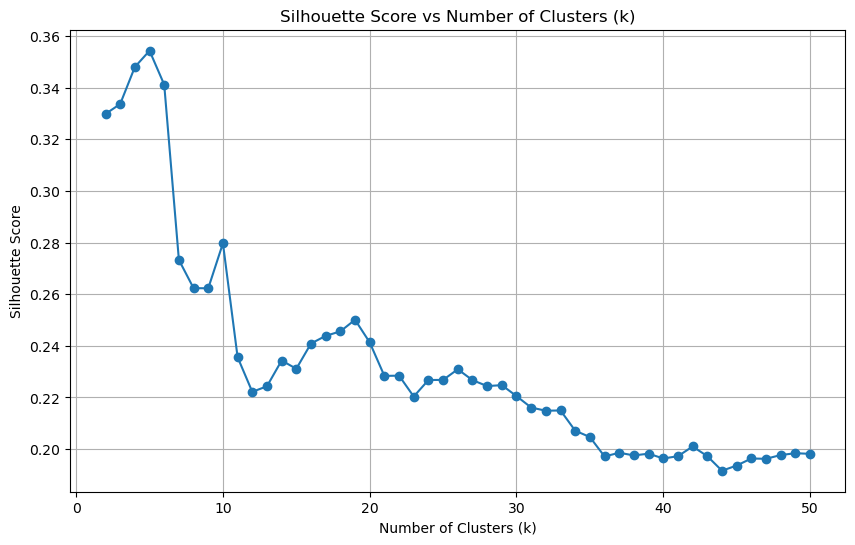

✅ Best number of clusters based on Silhouette Score: 5


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# === Step 1: Read the full dataset into a new DataFrame ===
file_path = "../data/Frogs_MFCCs.csv"
df_unsup = pd.read_csv(file_path)  # New name for unsupervised learning

# Use only the MFCC features (first 22 columns)
X_unsup = df_unsup.iloc[:, :22].values

# Standardize the data
scaler = StandardScaler()
X_scaled_unsup = scaler.fit_transform(X_unsup)

# === Step 2: Evaluate silhouette scores for different k ===
silhouette_scores = []
K_range = range(2, 51)  # trying k = 2 to 50

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled_unsup)
    score = silhouette_score(X_scaled_unsup, labels)
    silhouette_scores.append(score)

# === Step 3: Plot the silhouette scores ===
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# === Step 4: Report best k ===
best_k = K_range[np.argmax(silhouette_scores)]
print(f"✅ Best number of clusters based on Silhouette Score: {best_k}")

(b) In each cluster, determine which family is the majority by reading the true labels.
Repeat for genus and species.

In [ ]:
from sklearn.cluster import KMeans

# Refit KMeans with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled_unsup)

# Add cluster assignments to original DataFrame
df_unsup['Cluster'] = cluster_labels

# Define a helper function to print majority class in each cluster
def print_majority_per_cluster(df, label_col):
    print(f"\n🔍 Majority {label_col} in each cluster:")
    for cluster_id in sorted(df['Cluster'].unique()):
        cluster_subset = df[df['Cluster'] == cluster_id]
        most_common = cluster_subset[label_col].value_counts().idxmax()
        count = cluster_subset[label_col].value_counts().max()
        print(f"Cluster {cluster_id}: {most_common} ({count} samples)")

# Evaluate majority label for each of the 3 columns
print_majority_per_cluster(df_unsup, 'Family')
print_majority_per_cluster(df_unsup, 'Genus')
print_majority_per_cluster(df_unsup, 'Species')


🔍 Majority Family in each cluster:
Cluster 0: Leptodactylidae (3463 samples)
Cluster 1: Hylidae (564 samples)
Cluster 2: Leptodactylidae (383 samples)
Cluster 3: Leptodactylidae (284 samples)
Cluster 4: Hylidae (1383 samples)

🔍 Majority Genus in each cluster:
Cluster 0: Adenomera (3463 samples)
Cluster 1: Hypsiboas (519 samples)
Cluster 2: Adenomera (366 samples)
Cluster 3: Adenomera (277 samples)
Cluster 4: Hypsiboas (1040 samples)

🔍 Majority Species in each cluster:
Cluster 0: AdenomeraHylaedactylus (3463 samples)
Cluster 1: HypsiboasCinerascens (453 samples)
Cluster 2: AdenomeraAndre (366 samples)
Cluster 3: AdenomeraAndre (277 samples)
Cluster 4: HypsiboasCordobae (1037 samples)


(c) Now for each cluster you have a majority label triplet (family, genus, species).
Calculate the average Hamming distance, Hamming score, and Hamming loss
between the true labels and the labels assigned by clusters.

In [ ]:
import numpy as np

# Convert to NumPy arrays
y_true = true_labels.values
y_pred = pred_labels.values

# Hamming Distance (number of label mismatches per sample)
hamming_distances = np.sum(y_true != y_pred, axis=1)
avg_hamming_distance = np.mean(hamming_distances)

# Hamming Loss: fraction of wrong labels
hamming_loss_value = np.mean(y_true != y_pred)

# Hamming Score: fraction of correct labels per instance, averaged over all samples
hamming_scores = np.sum(y_true == y_pred, axis=1) / y_true.shape[1]
avg_hamming_score = np.mean(hamming_scores)

# Print results
print(f"🔢 Average Hamming Distance: {avg_hamming_distance:.4f}")
print(f"⚠️ Hamming Loss: {hamming_loss_value:.4f}")
print(f"✅ Hamming Score: {avg_hamming_score:.4f}")

🔢 Average Hamming Distance: 0.5903
⚠️ Hamming Loss: 0.1968
✅ Hamming Score: 0.8032


#### 3. ISLR 12.6.2

Suppose that we have four observations, for which we compute a dissimilarity matrix, given by:

```
⎡     0.3 0.4 0.7 ⎤
⎢ 0.3     0.5 0.8 ⎥
⎢ 0.4 0.5     0.45⎥
⎣ 0.7 0.8 0.45    ⎦
```

For instance, the dissimilarity between the first and second observations is 0.3, and the dissimilarity between the second and fourth observations is 0.8.

(a) On the basis of this dissimilarity matrix, sketch the dendrogram that results from hierarchically clustering these four observations using complete linkage. Be sure to indicate on the plot the height at which each fusion occurs, as well as the observations corresponding to each leaf in the dendrogram.

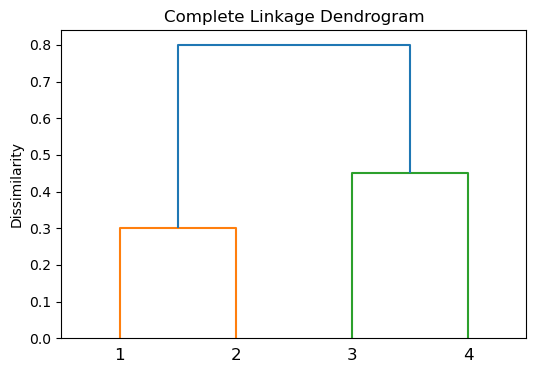

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import numpy as np

# Dissimilarity matrix
dissimilarity = np.array([
    [0.0, 0.3, 0.4, 0.7],
    [0.3, 0.0, 0.5, 0.8],
    [0.4, 0.5, 0.0, 0.45],
    [0.7, 0.8, 0.45, 0.0]
])

# Convert to condensed form
condensed = squareform(dissimilarity)

# Complete linkage clustering
Z_complete = linkage(condensed, method='complete')

# Dendrogram
plt.figure(figsize=(6, 4))
dendrogram(Z_complete, labels=[1, 2, 3, 4])
plt.title("Complete Linkage Dendrogram")
plt.ylabel("Dissimilarity")
plt.show()

(b) Repeat (a), this time using single linkage clustering.

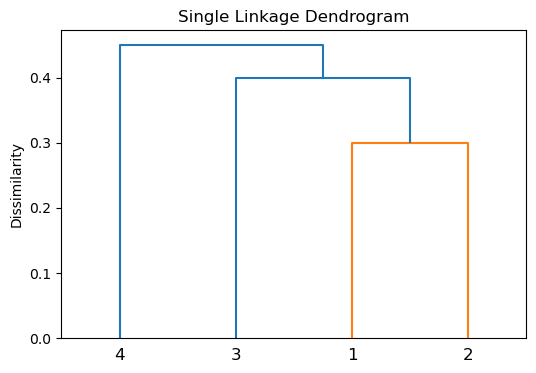

In [21]:
# Single linkage clustering
Z_single = linkage(condensed, method='single')

# Dendrogram
plt.figure(figsize=(6, 4))
dendrogram(Z_single, labels=[1, 2, 3, 4])
plt.title("Single Linkage Dendrogram")
plt.ylabel("Dissimilarity")
plt.show()

(c) Suppose that we cut the dendrogram obtained in (a) such that two clusters result. Which observations are in each cluster?

In [22]:
from scipy.cluster.hierarchy import fcluster

clusters_complete = fcluster(Z_complete, 2, criterion='maxclust')
print("Complete Linkage Clusters (2 groups):", clusters_complete)

Complete Linkage Clusters (2 groups): [1 1 2 2]


Cluster 1: Observations 1 and 2  
Cluster 2: Observations 3 and 4

(d) Suppose that we cut the dendrogram obtained in (b) such that
two clusters result. Which observations are in each cluster?

In [23]:
clusters_single = fcluster(Z_single, 2, criterion='maxclust')
print("Single Linkage Clusters (2 groups):", clusters_single)

Single Linkage Clusters (2 groups): [1 1 1 2]


Cluster 1: Observations 1, 2, 3  
Cluster 2: Observation 4

(e) It is mentioned in the chapter that at each fusion in the dendrogram, the position of the two clusters being fused can be
swapped without changing the meaning of the dendrogram. Draw
a dendrogram that is equivalent to the dendrogram in (a), for
which two or more of the leaves are repositioned, but for which
the meaning of the dendrogram is the same.

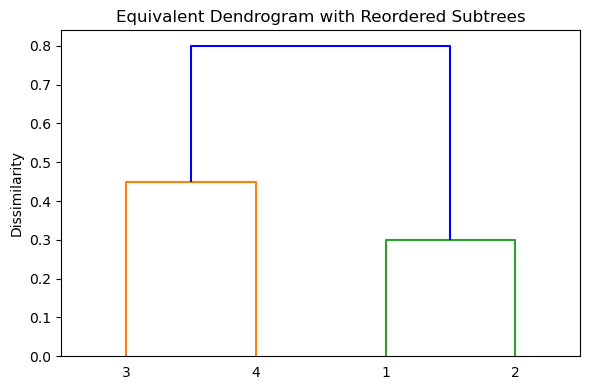

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform

# === Step 1: Original dissimilarity matrix ===
dissimilarity = np.array([
    [0.0, 0.3, 0.4, 0.7],
    [0.3, 0.0, 0.5, 0.8],
    [0.4, 0.5, 0.0, 0.45],
    [0.7, 0.8, 0.45, 0.0]
])

# === Step 2: Convert to condensed distance format required by scipy ===
condensed = squareform(dissimilarity)

# === Step 3: Perform complete linkage hierarchical clustering ===
Z_complete = linkage(condensed, method='complete')

# === Step 4: Modify the linkage matrix to reorder the merge ===
# Copy the original linkage matrix to avoid modifying it directly
Z_equiv = Z_complete.copy()

# Swap the order of the third merge (last row of Z matrix)
# Original: [2, 3, 0.8, 4] -> Swapped: [3, 2, 0.8, 4]
Z_equiv[2, 0], Z_equiv[2, 1] = Z_equiv[2, 1], Z_equiv[2, 0]

# === Step 5: Plot the equivalent dendrogram with reordered subtree ===
plt.figure(figsize=(6, 4))
dendrogram(
    Z_equiv,
    labels=[1, 2, 3, 4],         # Original observation labels
    leaf_font_size=10,
    orientation='top',
    above_threshold_color='blue'
)
plt.title("Equivalent Dendrogram with Reordered Subtrees")
plt.ylabel("Dissimilarity")
plt.tight_layout()
plt.show()